# Wine Price Time Series Analysis

In this notebook, I'm going to analyze wine prices using domestic wine production, exports, imports, average wine prices, and population datasets.

## Contents

1. Setup
2. Granger Causality Tests
3. Stationarity Transformations
4. Modeling
    - Lag Order Selection
    - Fit the Model
    - Serial Correlation of Residuals
    - Forecasting
    - Accuracy
5. Conclusion

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Making plots a bit more accessible
style.use('fivethirtyeight')
sns.set_palette('colorblind')

### Import Data

In [3]:
df = pd.read_excel('../data/master-data.xlsx')
df.head()

,Unnamed: 0,month,population,price,price_adj,bulk,bottled,cider,effervescent,wine_gross,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
0,0,2000-01-31,281083000,5.458,5.299029,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
1,1,2000-02-29,281299000,5.256,5.198813,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2,2,2000-03-31,281531000,5.471,5.311650,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
3,3,2000-04-30,281763000,5.156,5.104950,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
4,4,2000-05-31,281996000,5.530,5.426889,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


In [4]:
df.set_index('month', inplace=True)
df.head()

,Unnamed: 0,population,price,price_adj,bulk,bottled,cider,effervescent,wine_gross,bulk_adj,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0,281083000,5.458,5.299029,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,0.402552,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
2000-02-29,1,281299000,5.256,5.198813,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,0.255222,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2000-03-31,2,281531000,5.471,5.311650,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,0.164658,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
2000-04-30,3,281763000,5.156,5.104950,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,0.117003,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
2000-05-31,4,281996000,5.530,5.426889,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,0.112698,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


In [5]:
# the cider values aren't all available
df.drop(columns=['Unnamed: 0', 'cider', 'cider_adj'], inplace=True)

# move price to be first column
first_column = df.pop('price_adj')
df.insert(0, 'price_adj', first_column)

In [6]:
df.head()

,price_adj,population,price,bulk,bottled,effervescent,wine_gross,bulk_adj,bottled_adj,effervescent_adj,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,5.458,1.131505e+08,1.244070e+08,6.909175e+06,2.444667e+08,0.402552,0.442599,0.024581,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
2000-02-29,5.198813,281299000,5.256,7.179357e+07,1.375283e+08,4.377026e+06,2.136989e+08,0.255222,0.488904,0.015560,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2000-03-31,5.311650,281531000,5.471,4.635628e+07,1.603837e+08,9.321474e+06,2.160614e+08,0.164658,0.569684,0.033110,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
2000-04-30,5.104950,281763000,5.156,3.296724e+07,1.423004e+08,7.881046e+06,1.811036e+08,0.117003,0.505036,0.027970,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
2000-05-31,5.426889,281996000,5.530,3.178035e+07,1.612658e+08,6.334834e+06,1.924214e+08,0.112698,0.571873,0.022464,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


Before getting started, let's split the data into test and train sets. I'll store off the last three datapoints for later right now so that we don't inadvertantly bias our results.

In [7]:
obs = 3
train_df, test_df = df.dropna()[0:-obs].copy(), df.dropna()[-obs:].copy()

## Granger Causality Tests

In [8]:
maxlag=16
test = 'ssr_chi2test'
# Adopted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def grangers_causation_matrix(data, variables, test=test, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    granger_df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in granger_df.columns:
        for r in granger_df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=16, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            granger_df.loc[r, c] = min_p_value
    granger_df.columns = [var + '_x' for var in variables]
    granger_df.index = [var + '_y' for var in variables]
    
    return granger_df

In [9]:
granger_results = grangers_causation_matrix(data=train_df, variables=train_df.columns)
granger_results.to_excel('../granger_results_master_df_2.xlsx')

I've identified some variables that pass the granger causality test, indicating they likely have an effect on price. I'm isolating these variables for input into the model.

In [10]:
train_df = train_df[['price_adj', 'population', 'bottled', 'quantity_exports', 'calculated_duties_adj_ukfrspde_imports', 'dutiable_value_adj_ukfrspde_imports', 'charges_insurance_freight_adj_world_imports', 'quantity_world_imports', 'quantity_ukfrspde_imports', 'frspger_25']].copy()
test_df = test_df[['price_adj', 'population', 'bottled', 'quantity_exports', 'calculated_duties_adj_ukfrspde_imports', 'dutiable_value_adj_ukfrspde_imports', 'charges_insurance_freight_adj_world_imports', 'quantity_world_imports', 'quantity_ukfrspde_imports', 'frspger_25']].copy()

I'm going to do a couple of quick transformations and rename some variables.

In [11]:
train_df['prop_imp'] = train_df['quantity_ukfrspde_imports'] / (train_df['quantity_world_imports'] - train_df['quantity_ukfrspde_imports'])
train_df['calc_duty_rate'] = train_df['calculated_duties_adj_ukfrspde_imports'] / train_df['quantity_ukfrspde_imports']

test_df['prop_imp'] = test_df['quantity_ukfrspde_imports'] / (test_df['quantity_world_imports'] - test_df['quantity_ukfrspde_imports'])
test_df['calc_duty_rate'] = test_df['calculated_duties_adj_ukfrspde_imports'] / test_df['quantity_ukfrspde_imports']

train_df.drop(columns=['dutiable_value_adj_ukfrspde_imports'], inplace=True)
train_df.rename(columns={
    'quantity_exports': 'exp_q',
    'quantity_ukfrspde_imports': 'imp_q',
    'quantity_world_imports': 'imp_q_w',
    'calculated_duties_adj_ukfrspde_imports': 'calc_duty',
    'charges_insurance_freight_adj_world_imports': 'cif_w',
    'price_adj': 'price',
    'population': 'pop',
    'frspger_25': 'tariff'
}, inplace=True)

test_df.drop(columns=['dutiable_value_adj_ukfrspde_imports'], inplace=True)
test_df.rename(columns={
    'quantity_exports': 'exp_q',
    'quantity_ukfrspde_imports': 'imp_q',
    'quantity_world_imports': 'imp_q_w',
    'calculated_duties_adj_ukfrspde_imports': 'calc_duty',
    'charges_insurance_freight_adj_world_imports': 'cif_w',
    'price_adj': 'price',
    'population': 'pop',
    'frspger_25': 'tariff'
}, inplace=True)

# provide the same datapoints and renaming to the original dataframe for prediction
df['prop_imp'] = df['quantity_ukfrspde_imports'] / (df['quantity_world_imports'] - df['quantity_ukfrspde_imports'])
df['calc_duty_rate'] = df['calculated_duties_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df.rename(columns={
    'price': 'price_nom'
}, inplace=True)
df.rename(columns={
    'quantity_exports': 'exp_q',
    'quantity_ukfrspde_imports': 'imp_q',
    'quantity_world_imports': 'imp_q_w',
    'calculated_duties_adj_ukfrspde_imports': 'calc_duty',
    'charges_insurance_freight_adj_world_imports': 'cif_w',
    'price_adj': 'price',
    'population': 'pop',
    'frspger_25': 'tariff'
}, inplace=True)

In [12]:
train_df.head()

,price,pop,bottled,exp_q,calc_duty,cif_w,imp_q_w,imp_q,tariff,prop_imp,calc_duty_rate
month,,,,,,,,,,,
2000-01-31,5.299029,281083000,1.244070e+08,22385348,678934.951456,6.853057e+06,30869692,8768676,0,0.396754,0.077427
2000-02-29,5.198813,281299000,1.375283e+08,20954045,848555.885262,6.089141e+06,27334547,8961916,0,0.487786,0.094685
2000-03-31,5.311650,281531000,1.603837e+08,20240059,887386.407767,7.495030e+06,33950034,10474993,0,0.446218,0.084715
2000-04-30,5.104950,281763000,1.423004e+08,21745478,965145.544554,8.363492e+06,37381318,11128077,0,0.423874,0.086731
2000-05-31,5.426889,281996000,1.612658e+08,22059299,880599.607458,8.921802e+06,38726698,10874051,0,0.390414,0.080982


In [13]:
gc_test_results = grangers_causation_matrix(data=train_df.dropna(), variables=train_df.columns)
granger_results.to_excel('../gc-test-results.xlsx')
gc_test_results

,price_x,pop_x,bottled_x,exp_q_x,calc_duty_x,cif_w_x,imp_q_w_x,imp_q_x,tariff_x,prop_imp_x,calc_duty_rate_x
price_y,1.0000,0.0000,0.0000,0.0008,0.0285,0.0000,0.0000,0.0000,0.0486,0.0000,0.1081
pop_y,0.0002,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000
bottled_y,0.0000,0.0000,1.0000,0.0000,0.0028,0.0000,0.0000,0.0000,0.0411,0.0000,0.0247
exp_q_y,0.0440,0.0000,0.0000,1.0000,0.3566,0.0000,0.0000,0.0000,0.4222,0.0000,0.3796
calc_duty_y,0.4525,0.0000,0.0481,0.7098,1.0000,0.0014,0.0000,0.0000,0.0000,0.0107,0.0000
cif_w_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
imp_q_w_y,0.0000,0.0000,0.0000,0.0000,0.0036,0.0000,1.0000,0.0001,0.0057,0.0001,0.0192
imp_q_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
tariff_y,0.6177,0.0001,0.2018,0.5110,0.0000,0.0086,0.0002,0.0082,1.0000,0.5843,0.0000
prop_imp_y,0.0001,0.0000,0.0000,0.0000,0.0268,0.0000,0.0000,0.0000,0.0669,1.0000,0.0071


In [14]:
print(gc_test_results.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  price\_x &   pop\_x &  bottled\_x &  exp\_q\_x &  calc\_duty\_x &  cif\_w\_x &  imp\_q\_w\_x &  imp\_q\_x &  tariff\_x &  prop\_imp\_x &  calc\_duty\_rate\_x \\
\midrule
price\_y          &   1.0000 &  0.0000 &     0.0000 &   0.0008 &       0.0285 &   0.0000 &     0.0000 &   0.0000 &    0.0486 &      0.0000 &            0.1081 \\
pop\_y            &   0.0002 &  1.0000 &     0.0000 &   0.0000 &       0.0000 &   0.0000 &     0.0000 &   0.0000 &    0.0000 &      0.0001 &            0.0000 \\
bottled\_y        &   0.0000 &  0.0000 &     1.0000 &   0.0000 &       0.0028 &   0.0000 &     0.0000 &   0.0000 &    0.0411 &      0.0000 &            0.0247 \\
exp\_q\_y          &   0.0440 &  0.0000 &     0.0000 &   1.0000 &       0.3566 &   0.0000 &     0.0000 &   0.0000 &    0.4222 &      0.0000 &            0.3796 \\
calc\_duty\_y      &   0.4525 &  0.0000 &     0.0481 &   0.7098 &       1.0000 &   0.0014 &     0.0000 &   0.0000 &    0.0000 &      0.0

## Stationary Transformation

Before getting started, let's define the Dickey-Fuller test for checking for stationarity.

The hypothesis for the Augmented Dickey-Fuller test is as follows:
$$h_0: \text{The series has a unit root}$$
$$h_1: \text{The series does not have a unit root}$$

In [15]:
def adf(col):
   print('Augmented Dickey-Fuller Test:')
   unit_root_test = adfuller(col, autolag='AIC')
   dfoutput = pd.Series(unit_root_test[0:4], index=['t-stat:','p-value:','lags:','observations:'])
   for key, value in unit_root_test[4].items():
      dfoutput['critical value (%s):' % key] = value
   print (dfoutput)

Let's convert the tariff indicator to be a boolean in order to use it to help indentify the time period with the additional tariff.

In [16]:
# Convert the additional 25% tariff indicator to a boolean
train_df['tariff'] = train_df['tariff'].astype('bool')

### Price

Let's start with the price data.

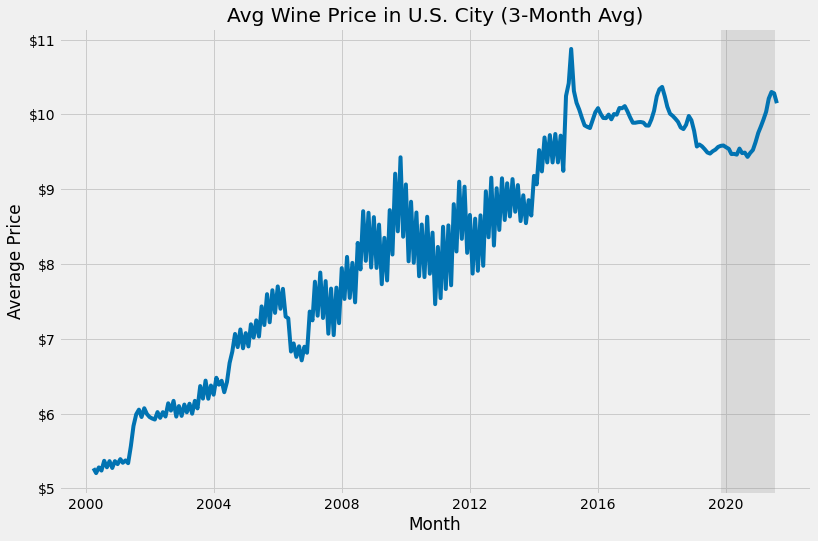

In [17]:
price_line_plot = sns.lineplot(data=train_df['price'].rolling(3).mean())
price_line_plot.set(title='Avg Wine Price in U.S. City (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.0f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city.png')
plt.show()

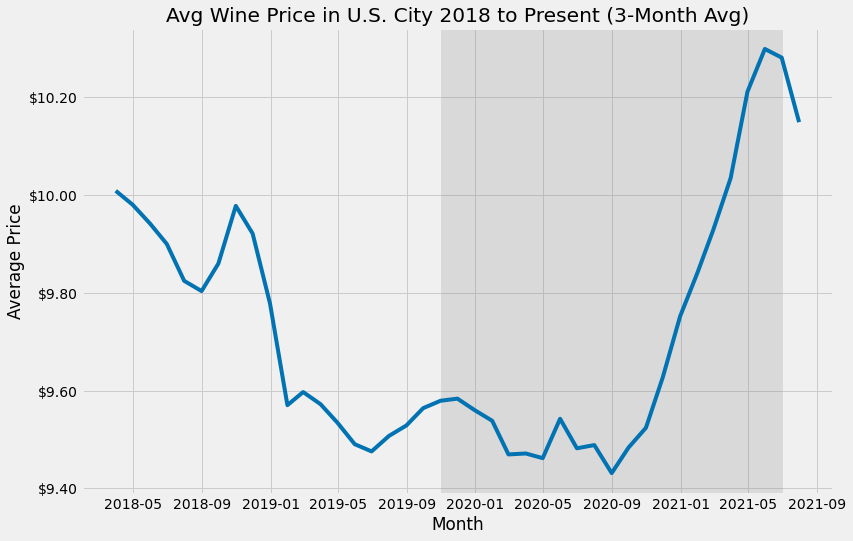

In [18]:
price_line_2018_plot = sns.lineplot(data=train_df.loc['2018-01-01':'2021-12-31']['price'].rolling(3).mean())
price_line_2018_plot.set(title='Avg Wine Price in U.S. City 2018 to Present (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_2018_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_2018_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.2f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city-2018.png')
plt.show()

Alright, let's run the augmented Dickey-Fuller test.

In [19]:
adf(train_df['price'])

Augmented Dickey-Fuller Test:
t-stat:                   -1.752900
p-value:                   0.404083
lags:                      9.000000
observations:            249.000000
critical value (1%):      -3.456888
critical value (5%):      -2.873219
critical value (10%):     -2.572994
dtype: float64


Since the test statistic is greater than the critical value (at the 5% level), we fail to reject the null hypothesis; the series doesn't have a unit root and is therefore non-stationary.

So I do need to make some adjustments to the series to make it stationary.

First, let's decompose the series into its trend, seasonality, and noise.

In [20]:
style.use('default')

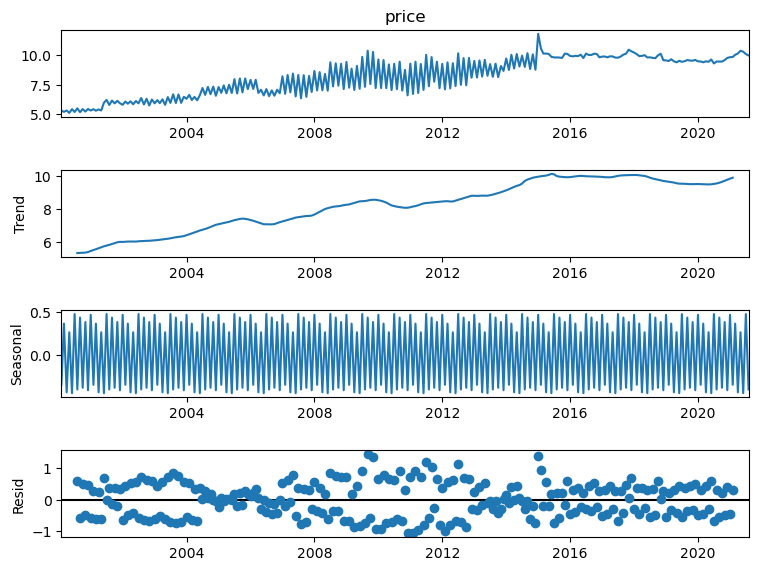

In [21]:
decompose_result_mult = seasonal_decompose(train_df['price'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.gcf().set_size_inches(8, 6)
plt.show()

In [22]:
price_diff1 = train_df['price'] - train_df['price'].shift(1)

In [23]:
adf(price_diff1.dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -7.945086e+00
p-value:                 3.236057e-12
lags:                    8.000000e+00
observations:            2.490000e+02
critical value (1%):    -3.456888e+00
critical value (5%):    -2.873219e+00
critical value (10%):   -2.572994e+00
dtype: float64


It looks like taking the first difference of the data worked to pass the Dickey-Fuller test.

In [24]:
train_df['price_diff1'] = price_diff1

We'll need to do this same process on the original dataset in order to have the differenced values available for our test set. This is because the test set only has 3 datapoints and therefore isn't able to dip backward more than 3 months.

In [25]:
df['price_diff1'] = df['price'] - df['price'].shift(1)

### Domestic Wine Production

#### Bottled

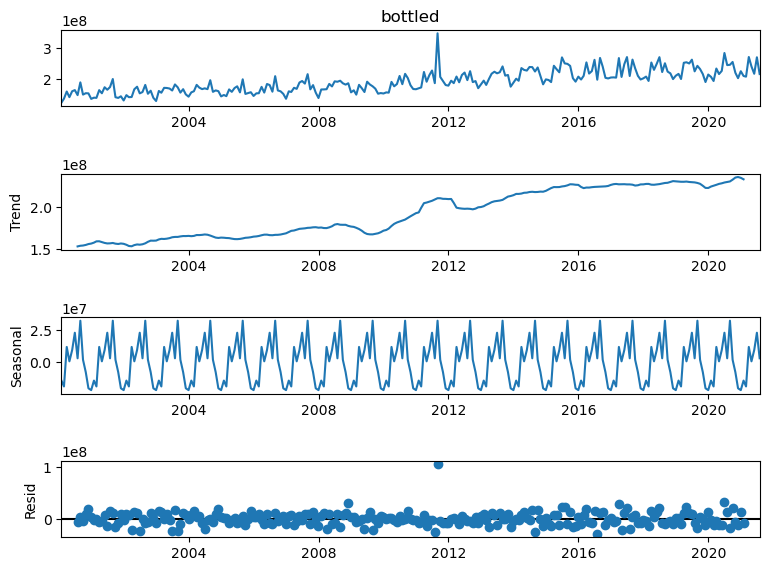

In [26]:
decompose_result_mult = seasonal_decompose(train_df['bottled'], model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.gcf().set_size_inches(8, 6)
plt.show()

It definitely looks like there's an upward trend and seasonality in the data. Let's take a closer look at the seasonality to help identify the cycle.

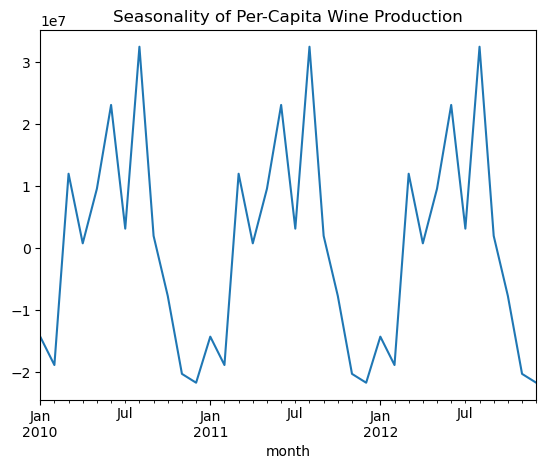

In [27]:
seasonality_bottled_plot = seasonal['2010-01-01':'2013-01-01'].plot()
seasonality_bottled_plot.set(title='Seasonality of Per-Capita Wine Production')
plt.show()

In [28]:
bottled_diff1 = train_df['bottled'] - train_df['bottled'].shift(1)
bottled_diff1_diff12 = bottled_diff1 - bottled_diff1.shift(12)

In [29]:
adf(bottled_diff1_diff12.dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.886175e+00
p-value:                 1.392771e-09
lags:                    1.500000e+01
observations:            2.300000e+02
critical value (1%):    -3.459106e+00
critical value (5%):    -2.874190e+00
critical value (10%):   -2.573512e+00
dtype: float64


It looks like taking the second diff worked and we're now passing the ADF test.

In [30]:
train_df['bottled_diff1_diff12'] = bottled_diff1_diff12

In [31]:
train_df.head()

,price,pop,bottled,exp_q,calc_duty,cif_w,imp_q_w,imp_q,tariff,prop_imp,calc_duty_rate,price_diff1,bottled_diff1_diff12
month,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,1.244070e+08,22385348,678934.951456,6.853057e+06,30869692,8768676,False,0.396754,0.077427,NaN,NaN
2000-02-29,5.198813,281299000,1.375283e+08,20954045,848555.885262,6.089141e+06,27334547,8961916,False,0.487786,0.094685,-0.100216,NaN
2000-03-31,5.311650,281531000,1.603837e+08,20240059,887386.407767,7.495030e+06,33950034,10474993,False,0.446218,0.084715,0.112837,NaN
2000-04-30,5.104950,281763000,1.423004e+08,21745478,965145.544554,8.363492e+06,37381318,11128077,False,0.423874,0.086731,-0.206700,NaN
2000-05-31,5.426889,281996000,1.612658e+08,22059299,880599.607458,8.921802e+06,38726698,10874051,False,0.390414,0.080982,0.321939,NaN


In [32]:
# provide the same datapoint to original dataframe
df['bottled_diff1_diff12'] = (df['bottled'] - df['bottled'].shift(1)) - (df['bottled'] - df['bottled'].shift(1)).shift(12)

### Wine Exports

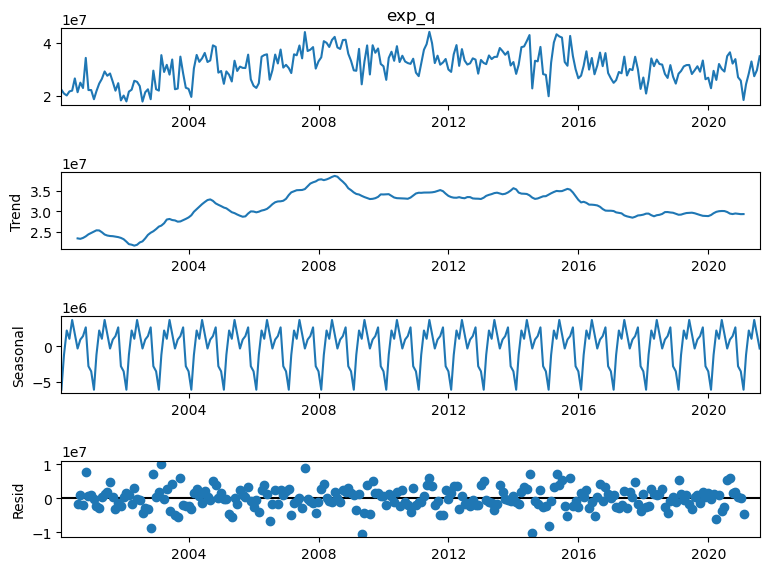

In [33]:
decompose_result_mult = seasonal_decompose(train_df['exp_q'], model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.gcf().set_size_inches(8, 6)
plt.show()

In [34]:
exp_q_diff1 = train_df['exp_q'] - train_df['exp_q'].shift(1)
exp_q_diff1_diff12 = exp_q_diff1 - exp_q_diff1.shift(12)

In [35]:
adf(exp_q_diff1.dropna())
adf(exp_q_diff1_diff12.dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -1.088854e+01
p-value:                 1.242052e-19
lags:                    1.000000e+01
observations:            2.470000e+02
critical value (1%):    -3.457105e+00
critical value (5%):    -2.873314e+00
critical value (10%):   -2.573044e+00
dtype: float64
Augmented Dickey-Fuller Test:
t-stat:                 -7.015780e+00
p-value:                 6.738828e-10
lags:                    1.400000e+01
observations:            2.310000e+02
critical value (1%):    -3.458980e+00
critical value (5%):    -2.874135e+00
critical value (10%):   -2.573482e+00
dtype: float64


In [36]:
train_df['exp_q_diff1_diff12'] = exp_q_diff1_diff12

In [37]:
# provide the same datapoint to original dataframe
df['exp_q_diff1_diff12'] = (df['exp_q'] - df['exp_q'].shift(1)) - (df['exp_q'] - df['exp_q'].shift(1)).shift(12)

### Imports

#### Calculated Duties

In [38]:
adf(train_df['calc_duty'])
adf(train_df['calc_duty_rate'])

Augmented Dickey-Fuller Test:
t-stat:                 -6.167433e+00
p-value:                 6.935170e-08
lags:                    1.600000e+01
observations:            2.420000e+02
critical value (1%):    -3.457664e+00
critical value (5%):    -2.873559e+00
critical value (10%):   -2.573175e+00
dtype: float64
Augmented Dickey-Fuller Test:
t-stat:                   -5.043946
p-value:                   0.000018
lags:                     16.000000
observations:            242.000000
critical value (1%):      -3.457664
critical value (5%):      -2.873559
critical value (10%):     -2.573175
dtype: float64


It looks like it does pass the ADF. But let's look into the seasonal decomposition of it.

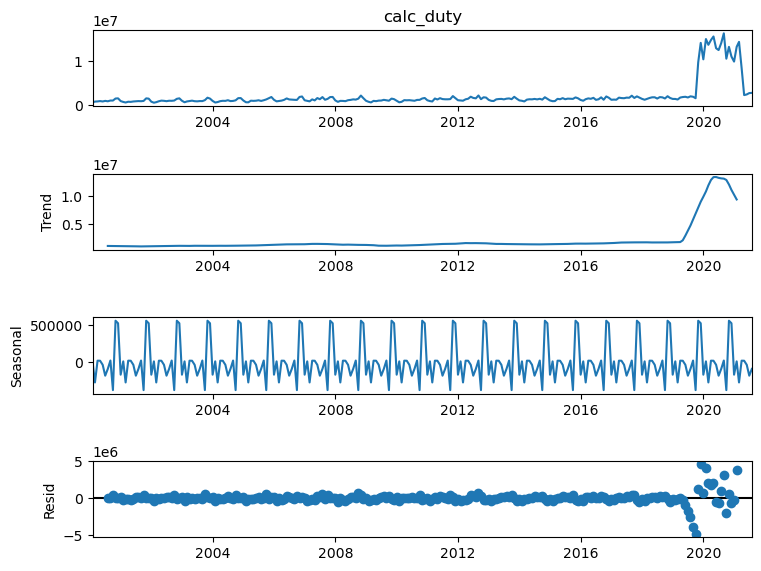

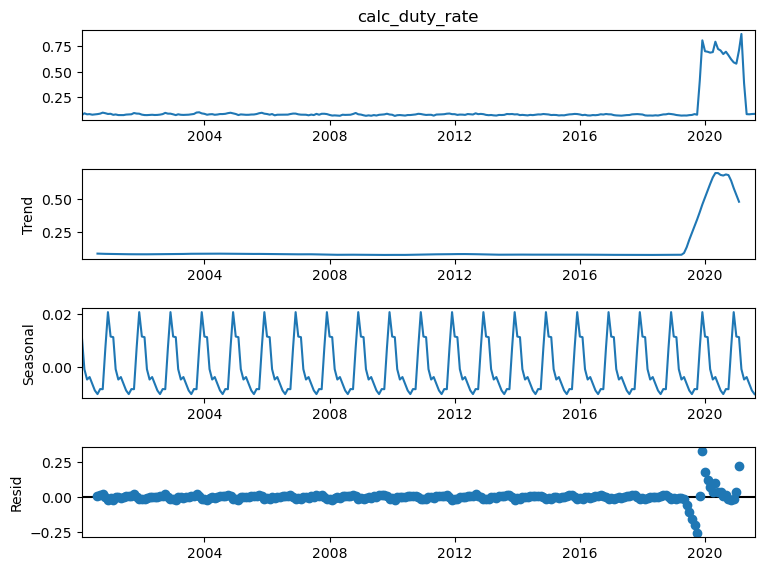

In [39]:
decompose_result_mult = seasonal_decompose(train_df['calc_duty'], model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.gcf().set_size_inches(8, 6)
plt.show()

decompose_result_mult = seasonal_decompose(train_df['calc_duty_rate'], model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.gcf().set_size_inches(8, 6)
plt.show()

Definitely seasonality to adjust for.

In [40]:
calc_duty_diff1 = train_df['calc_duty'] - train_df['calc_duty'].shift(1)
calc_duty_diff1_diff12 = calc_duty_diff1 - calc_duty_diff1.shift(12)

calc_duty_rate_diff1 = train_df['calc_duty_rate'] - train_df['calc_duty_rate'].shift(1)
calc_duty_rate_diff1_diff12 = calc_duty_rate_diff1 - calc_duty_rate_diff1.shift(12)

In [41]:
adf(calc_duty_diff1_diff12.dropna())
adf(calc_duty_rate_diff1_diff12.dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -4.948212
p-value:                   0.000028
lags:                     16.000000
observations:            229.000000
critical value (1%):      -3.459233
critical value (5%):      -2.874245
critical value (10%):     -2.573541
dtype: float64
Augmented Dickey-Fuller Test:
t-stat:                 -5.926046e+00
p-value:                 2.442361e-07
lags:                    1.600000e+01
observations:            2.290000e+02
critical value (1%):    -3.459233e+00
critical value (5%):    -2.874245e+00
critical value (10%):   -2.573541e+00
dtype: float64


In [42]:
train_df['calc_duty_diff1_diff12'] = calc_duty_diff1_diff12
train_df['calc_duty_rate_diff1_diff12'] = calc_duty_rate_diff1_diff12

In [43]:
# provide the same datapoints to original dataframe
df['calc_duty_diff1_diff12'] = (df['calc_duty'] - df['calc_duty'].shift(1)) - (df['calc_duty'] - df['calc_duty'].shift(1)).shift(12)
df['calc_duty_rate_diff1_diff12'] = (df['calc_duty_rate'] - df['calc_duty_rate'].shift(1)) - (df['calc_duty_rate'] - df['calc_duty_rate'].shift(1)).shift(12)

#### Charges, Insurance, and Freight

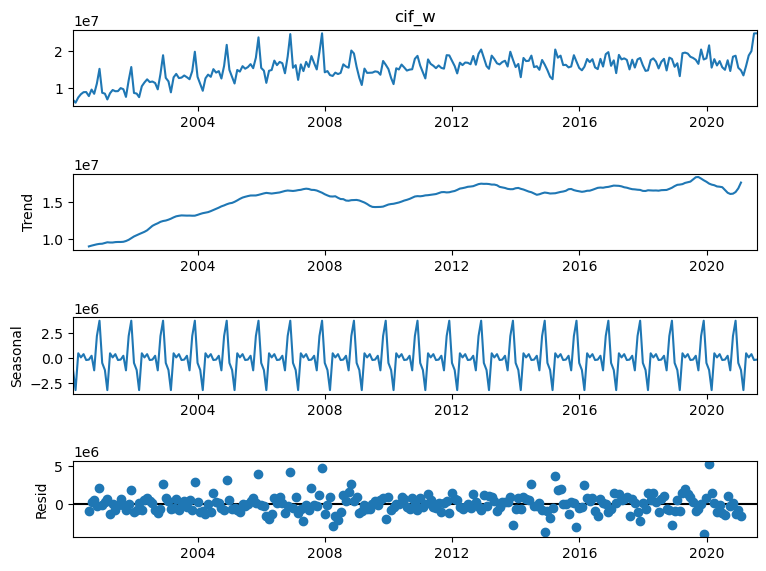

In [44]:
decompose_result_mult = seasonal_decompose(train_df['cif_w'], model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.gcf().set_size_inches(8, 6)
plt.show()

It looks like there's an upward trend and 12-month seasonality to the data.

In [45]:
adf(train_df['cif_w'])

Augmented Dickey-Fuller Test:
t-stat:                   -2.382361
p-value:                   0.146777
lags:                     16.000000
observations:            242.000000
critical value (1%):      -3.457664
critical value (5%):      -2.873559
critical value (10%):     -2.573175
dtype: float64


In [46]:
cif_w_diff1 = train_df['cif_w'] - train_df['cif_w'].shift(1)
cif_w_diff1_diff12 = cif_w_diff1 - cif_w_diff1.shift(12)

In [47]:
adf(cif_w_diff1_diff12.dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -5.627661
p-value:                   0.000001
lags:                     16.000000
observations:            229.000000
critical value (1%):      -3.459233
critical value (5%):      -2.874245
critical value (10%):     -2.573541
dtype: float64


In [48]:
train_df['cif_w_diff1_diff12'] = cif_w_diff1_diff12

In [49]:
# provide the same datapoint to original dataframe
df['cif_w_diff1_diff12'] = (df['cif_w'] - df['cif_w'].shift(1)) - (df['cif_w'] - df['cif_w'].shift(1)).shift(12)

#### Imports Quantities

In [50]:
adf(train_df['imp_q_w'])
adf(train_df['imp_q'])

Augmented Dickey-Fuller Test:
t-stat:                   -0.640725
p-value:                   0.861512
lags:                     12.000000
observations:            246.000000
critical value (1%):      -3.457215
critical value (5%):      -2.873362
critical value (10%):     -2.573070
dtype: float64
Augmented Dickey-Fuller Test:
t-stat:                   -0.299669
p-value:                   0.925551
lags:                     13.000000
observations:            245.000000
critical value (1%):      -3.457326
critical value (5%):      -2.873410
critical value (10%):     -2.573096
dtype: float64


In [51]:
imp_q_w_diff1 = train_df['imp_q_w'] - train_df['imp_q_w'].shift(1)
imp_q_w_diff1_diff12 = imp_q_w_diff1 - imp_q_w_diff1.shift(12)

adf(imp_q_w_diff1_diff12.dropna())

imp_q_diff1 = train_df['imp_q'] - train_df['imp_q'].shift(1)
imp_q_diff1_diff12 = imp_q_diff1 - imp_q_diff1.shift(12)

adf(imp_q_diff1_diff12.dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -5.339624
p-value:                   0.000005
lags:                     16.000000
observations:            229.000000
critical value (1%):      -3.459233
critical value (5%):      -2.874245
critical value (10%):     -2.573541
dtype: float64
Augmented Dickey-Fuller Test:
t-stat:                   -4.826469
p-value:                   0.000048
lags:                     13.000000
observations:            232.000000
critical value (1%):      -3.458855
critical value (5%):      -2.874080
critical value (10%):     -2.573453
dtype: float64


In [52]:
train_df['imp_q_w_diff1_diff12'] = imp_q_w_diff1_diff12
train_df['imp_q_diff1_diff12'] = imp_q_diff1_diff12

In [53]:
# provide the same datapoints to original dataframe
df['imp_q_w_diff1_diff12'] = (df['imp_q_w'] - df['imp_q_w'].shift(1)) - (df['imp_q_w'] - df['imp_q_w'].shift(1)).shift(12)
df['imp_q_diff1_diff12'] = (df['imp_q'] - df['imp_q'].shift(1)) - (df['imp_q'] - df['imp_q'].shift(1)).shift(12)

#### Quantity as a Proportion of World Imports

In [54]:
adf(train_df['prop_imp'])

Augmented Dickey-Fuller Test:
t-stat:                   -2.983807
p-value:                   0.036435
lags:                     13.000000
observations:            245.000000
critical value (1%):      -3.457326
critical value (5%):      -2.873410
critical value (10%):     -2.573096
dtype: float64


In [55]:
prop_imp_diff1 = train_df['prop_imp'] - train_df['prop_imp'].shift(1)
prop_imp_diff1_diff12 = prop_imp_diff1 - prop_imp_diff1.shift(12)

adf(prop_imp_diff1_diff12.dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.591816e+00
p-value:                 7.083434e-09
lags:                    1.300000e+01
observations:            2.320000e+02
critical value (1%):    -3.458855e+00
critical value (5%):    -2.874080e+00
critical value (10%):   -2.573453e+00
dtype: float64


In [56]:
train_df['prop_imp_diff1_diff12'] = prop_imp_diff1_diff12

In [57]:
# provide the same datapoint to original dataframe
df['prop_imp_diff1_diff12'] = (df['prop_imp'] - df['prop_imp'].shift(1)) - (df['prop_imp'] - df['prop_imp'].shift(1)).shift(12)

Now we've made everything stationary for the multivariate time series.

In [58]:
display(train_df.dropna().head())

,price,pop,bottled,exp_q,calc_duty,cif_w,imp_q_w,imp_q,tariff,prop_imp,calc_duty_rate,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,cif_w_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12
month,,,,,,,,,,,,,,,,,,,,
2001-02-28,5.294118,284166000,1.399831e+08,21849764,644654.901961,6.964608e+06,28818883,7739079,False,0.367132,0.083299,-0.129774,-1.376336e+07,4460939.0,-293478.555930,-0.013678,-797422.369520,-3389158.0,-2094399.0,-0.093215
2001-03-31,5.404831,284380000,1.648432e+08,24703070,815434.782609,8.634644e+06,35182803,10541409,False,0.427793,0.077355,0.110713,2.004731e+06,3567292.0,131949.358143,0.004027,264147.948335,-251567.0,1289253.0,0.102228
2001-04-30,5.314258,284602000,1.547780e+08,26482792,783855.480116,9.501456e+06,39651606,10167119,False,0.344829,0.077097,-0.090573,8.018131e+06,274303.0,-109338.439280,-0.002274,-1650.558476,1037519.0,-1027374.0,-0.060619
2001-05-31,5.973786,284834000,1.741018e+08,29263413,875348.543689,9.170823e+06,37803711,11354170,False,0.429277,0.077095,0.659528,3.583498e+05,2466800.0,176039.000669,0.005747,-888942.254348,-3193275.0,1441077.0,0.117908
2001-06-30,6.215800,285076000,1.661245e+08,27648099,928990.366089,9.201833e+06,38397664,11320315,False,0.418073,0.082064,0.242013,-1.166436e+07,-6205456.0,-75155.816947,0.002405,1200.196047,1031146.0,-1241802.0,-0.081803


In [59]:
style.use('fivethirtyeight')

### Johansen Test

In [60]:
train_df.columns

Index(['price', 'pop', 'bottled', 'exp_q', 'calc_duty', 'cif_w', 'imp_q_w',
       'imp_q', 'tariff', 'prop_imp', 'calc_duty_rate', 'price_diff1',
       'bottled_diff1_diff12', 'exp_q_diff1_diff12', 'calc_duty_diff1_diff12',
       'calc_duty_rate_diff1_diff12', 'cif_w_diff1_diff12',
       'imp_q_w_diff1_diff12', 'imp_q_diff1_diff12', 'prop_imp_diff1_diff12'],
      dtype='object')

In [61]:
johan_test_df = train_df[['price_diff1', 'calc_duty_diff1_diff12', 'calc_duty_rate_diff1_diff12', 'bottled_diff1_diff12', 
    'exp_q_diff1_diff12', 'prop_imp_diff1_diff12', 'imp_q_w_diff1_diff12', 'imp_q_diff1_diff12', 'cif_w_diff1_diff12']].copy()

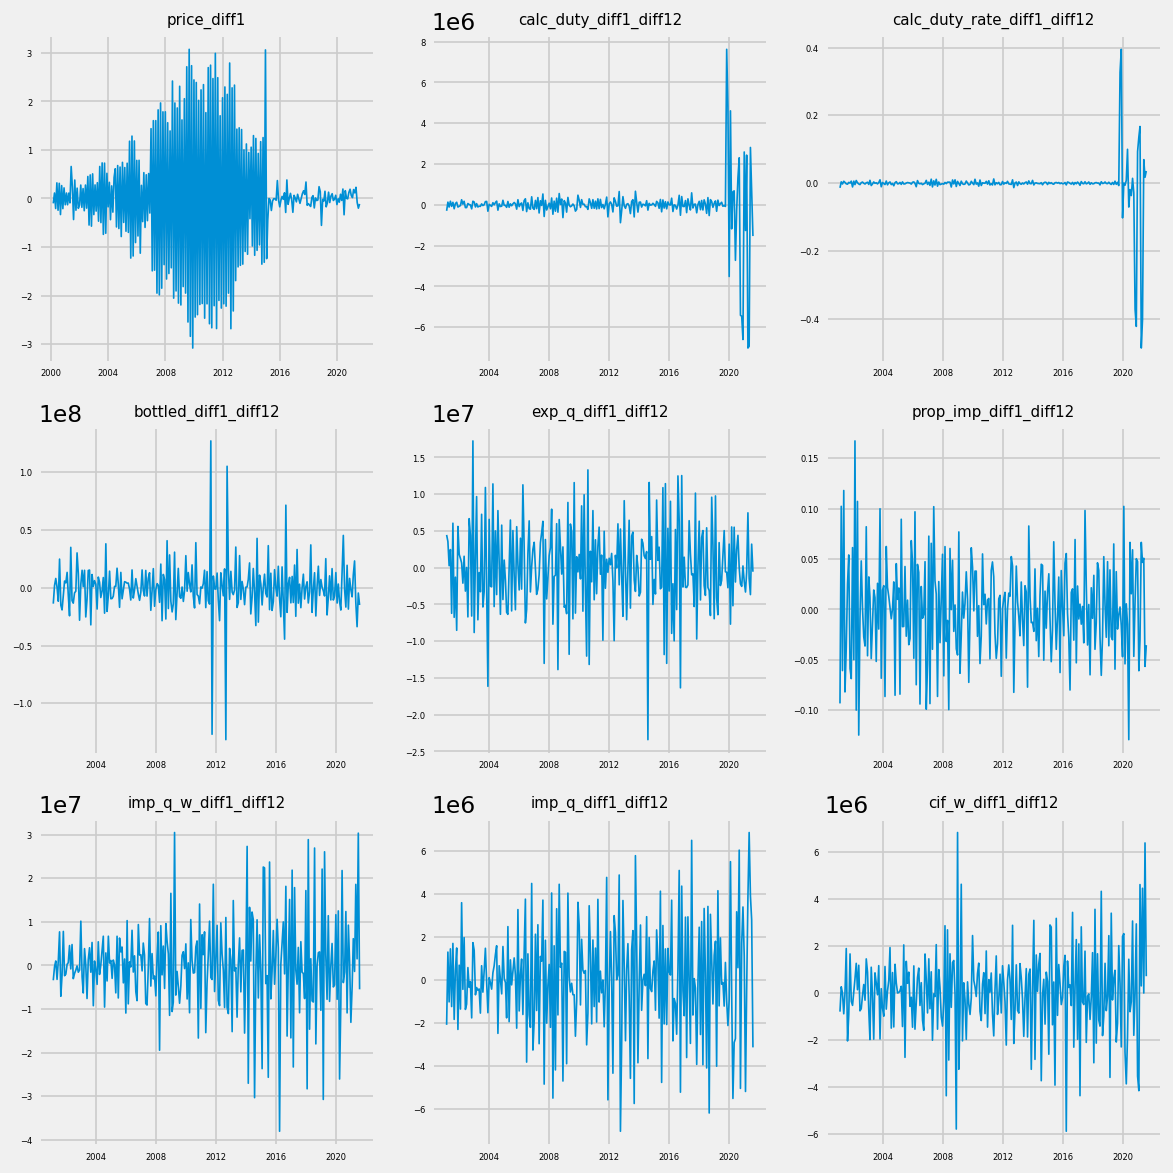

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = johan_test_df[johan_test_df.columns[i]]
    ax.plot(data, linewidth=1)

    ax.set_title(johan_test_df.columns[i], size=9)
    ax.tick_params(labelsize=5)

plt.tight_layout()
plt.show()

Let's define a function that provides a printout of the results of a cointegration johansen test of the variables for our analysis.

In [63]:
def johansen_test(var_df, critical_value=0.05): 
    output = coint_johansen(var_df, -1, 3)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    trace_stat = output.lr1
    cvt_values = output.cvt[:, d[str(1-critical_value)]]
    cvm_values = output.cvm[:, d[str(1-critical_value)]]

    print('Cointegration Johansen Test:')
    print('{:<30}'.format('Variable') + '{:<30}'.format('T-Stat > CVs (trace, eig)') + '{:<20}'.format('Significant'))
    print('--'*36)
    for col, trace, cvt, eig in zip(var_df.columns, trace_stat, cvt_values, cvm_values):
        print('{:<30}'.format(col) + '{:<30}'.format('{:<7}'.format(format(trace, '.2f')) + \
            ' > ' + '{:<9}'.format('(' + format(cvt, '.2f') + ', ') + '{:<7}'.format(format(eig, '.2f')  + ')')) + '{:<20}'.format(str(trace > cvt)))


In [64]:
johansen_test(johan_test_df.dropna())

Cointegration Johansen Test:
Variable                      T-Stat > CVs (trace, eig)     Significant         
------------------------------------------------------------------------
price_diff1                   1085.07 > (179.52, 54.96)     True                
calc_duty_diff1_diff12        825.38  > (143.67, 48.88)     True                
calc_duty_rate_diff1_diff12   653.64  > (111.78, 42.77)     True                
bottled_diff1_diff12          499.00  > (83.94,  36.63)     True                
exp_q_diff1_diff12            351.33  > (60.06,  30.44)     True                
prop_imp_diff1_diff12         233.72  > (40.17,  24.16)     True                
imp_q_w_diff1_diff12          152.35  > (24.28,  17.80)     True                
imp_q_diff1_diff12            87.48   > (12.32,  11.22)     True                
cif_w_diff1_diff12            27.21   > (4.13,   4.13)      True                


## Modeling

In [65]:
train_df

,price,pop,bottled,exp_q,calc_duty,cif_w,imp_q_w,imp_q,tariff,prop_imp,calc_duty_rate,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,cif_w_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12
month,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,1.244070e+08,22385348,6.789350e+05,6.853057e+06,30869692,8768676,False,0.396754,0.077427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,5.198813,281299000,1.375283e+08,20954045,8.485559e+05,6.089141e+06,27334547,8961916,False,0.487786,0.094685,-0.100216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,5.311650,281531000,1.603837e+08,20240059,8.873864e+05,7.495030e+06,33950034,10474993,False,0.446218,0.084715,0.112837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,5.104950,281763000,1.423004e+08,21745478,9.651455e+05,8.363492e+06,37381318,11128077,False,0.423874,0.086731,-0.206700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,5.426889,281996000,1.612658e+08,22059299,8.805996e+05,8.921802e+06,38726698,10874051,False,0.390414,0.080982,0.321939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,10.173180,331061000,2.713890e+08,28503040,8.458189e+06,1.600186e+07,104837000,21832976,True,0.263035,0.387404,0.115665,2.318849e+07,7459878.0,-7.021267e+06,-0.486090,3.031855e+05,-1364013.0,3837952.0,0.066511
2021-04-30,10.403817,331126000,2.409610e+08,33029459,2.322905e+06,1.877114e+07,109725863,26959638,True,0.325732,0.086162,0.230637,-1.270377e+07,-1475617.0,-6.934315e+06,-0.402339,4.467299e+06,18582587.0,6852096.0,0.046636
2021-05-31,10.319847,331204000,2.174436e+08,27474553,2.471585e+06,1.995182e+07,116560687,29104122,True,0.332784,0.084922,-0.083969,-3.371508e+07,-3662264.0,2.811094e+06,0.069568,-1.647857e+03,1530680.0,3901048.0,0.050748


In [66]:
train_df.columns

Index(['price', 'pop', 'bottled', 'exp_q', 'calc_duty', 'cif_w', 'imp_q_w',
       'imp_q', 'tariff', 'prop_imp', 'calc_duty_rate', 'price_diff1',
       'bottled_diff1_diff12', 'exp_q_diff1_diff12', 'calc_duty_diff1_diff12',
       'calc_duty_rate_diff1_diff12', 'cif_w_diff1_diff12',
       'imp_q_w_diff1_diff12', 'imp_q_diff1_diff12', 'prop_imp_diff1_diff12'],
      dtype='object')

In [67]:
model_cols = []
for c in train_df.columns:
    if 'diff' in c:
        model_cols.append(c)
train_mod_df = train_df[model_cols]

### Lag Order Selection

In [68]:

train_mod_df = train_mod_df.merge(df['tariff'], right_index=True, left_index=True)
train_mod_df.tail(20)

,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,cif_w_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12,tariff
month,,,,,,,,,,
2019-12-31,-0.125394,1.310091e+07,3209779.0,-3.511519e+06,-0.102282,2.414231e+06,11625817.0,-921142.0,-0.046902,1
2020-01-31,-0.005509,-1.324518e+07,-7676768.0,4.606757e+06,0.000687,2.533577e+06,-7745129.0,5496390.0,0.102164,1
2020-02-29,-0.075669,3.199135e+06,5538870.0,-1.178447e+06,-0.005890,-2.526829e+06,12499049.0,-564025.0,-0.053944,1
2020-03-31,0.086990,-1.211996e+07,-5170063.0,6.384296e+05,0.008416,-3.879000e+06,-26018159.0,-5516624.0,0.005592,1
2020-04-30,-0.040031,-1.930233e+07,5502357.0,6.848793e+05,0.100008,-1.863100e+06,-9032167.0,-2919327.0,-0.014728,1
2020-05-31,0.194765,1.405370e+07,-1948015.0,-2.721736e+06,-0.070339,1.438405e+06,21755836.0,-2735702.0,-0.129126,1
2020-06-30,-0.335844,4.527736e+07,2457504.0,-2.612884e+05,-0.018684,-8.004944e+05,-3928831.0,3162824.0,0.066458,1
2020-07-31,0.160821,-1.437465e+06,4404584.0,1.330928e+06,-0.036457,-3.673936e+05,-1536917.0,565801.0,0.015540,1
2020-08-31,0.003058,-1.672886e+07,-67390.0,2.305514e+06,0.014381,3.069378e+06,12357776.0,6032867.0,0.059102,1


In [69]:
train_mod_df.dropna(inplace=True)

In [70]:
train_mod_df[['tariff', 'cif_w_diff1_diff12']]

,tariff,cif_w_diff1_diff12
month,,
2001-02-28,0,-7.974224e+05
2001-03-31,0,2.641479e+05
2001-04-30,0,-1.650558e+03
2001-05-31,0,-8.889423e+05
2001-06-30,0,1.200196e+03
...,...,...
2021-03-31,1,3.031855e+05
2021-04-30,1,4.467299e+06
2021-05-31,1,-1.647857e+03


In [71]:
model = VAR(endog=train_mod_df.drop(columns=['tariff', 'cif_w_diff1_diff12']).dropna(), exog=train_mod_df[['tariff', 'cif_w_diff1_diff12']].dropna())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [72]:
lag_orders = model.select_order(maxlags=20)
lag_orders.summary()

,AIC,BIC,FPE,HQIC
0,138.9,139.3,2.204e+60,139.1
1,135.0,136.3*,4.167e+58,135.5
2,134.3,136.6,2.154e+58,135.2
3,134.2,137.5,1.963e+58,135.5
4,134.0,138.2,1.544e+58,135.7
5,133.7,138.9,1.186e+58,135.8
6,132.9,139.1,5.640e+57,135.4
7,132.6,139.7,4.112e+57,135.4
8,132.4,140.5,3.592e+57,135.7
9,131.3,140.4,1.317e+57,135.0


It looks like the recommendation is for a lag order of 1. Let's go with that.

### Fit the Model

In [73]:
tsmf = model.fit(1)
tsmf.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Feb, 2022
Time:                     18:20:13
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    136.249
Nobs:                     245.000    HQIC:                   135.497
Log likelihood:          -19229.5    FPE:                4.22697e+58
AIC:                      134.991    Det(Omega_mle):     2.97467e+58
--------------------------------------------------------------------
Results for equation price_diff1
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.036004         0.022007            1.636           0.102
tariff                                 0.030570         0.076066            0.402   

In [74]:
stable = tsmf.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.9683117481440149
0.17658986776618943
0.1410035279458379
0.3100486990892384
0.3100486990892384
0.48812140605571364
0.48812140605571364
0.5077592781904109


### Serial Correlation of Residuals

I'll use the Durbin Watson statistic for serial correlation. The value ranges from `0` to `4` with `0` indicating a positive correlation and `4` indicating a negative correlation. The value `2` is what the test aims for.

In [75]:
dw_output = durbin_watson(tsmf.resid)

for col, val in zip(train_mod_df.columns, dw_output):
    print('{:<62}'.format(str(col), ':'), round(val, 3))

price_diff1                                                    1.656
bottled_diff1_diff12                                           2.345
exp_q_diff1_diff12                                             2.173
calc_duty_diff1_diff12                                         1.999
calc_duty_rate_diff1_diff12                                    2.0
cif_w_diff1_diff12                                             2.509
imp_q_w_diff1_diff12                                           2.286
imp_q_diff1_diff12                                             2.083


This looks like we don't have any serial correlation in the residuals.

### Forecast

First, let's merge the model's variables from the original dataframe with `test_df` to get the proper differenced values.

In [76]:
test_df = test_df.merge(df[model_cols], left_index=True, right_index=True)

In [77]:
test_df.head()

,price,pop,bottled,exp_q,calc_duty,cif_w,imp_q_w,imp_q,tariff,prop_imp,calc_duty_rate,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,cif_w_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12
month,,,,,,,,,,,,,,,,,,,,
2021-08-31,9.872753,331507000,2.267857e+08,33356581,2.630996e+06,2.180433e+07,123645544,27746575,0,0.289331,0.094822,-0.135037,9.322928e+06,-3071363.0,-2.409875e+06,-0.016687,-5.487111e+06,-26406062.0,-6565751.0,-0.008706
2021-09-30,9.858122,331618000,2.196083e+08,25724825,2.275361e+06,2.016997e+07,111463896,24306408,0,0.278879,0.093612,-0.014630,-1.634241e+07,-3388574.0,5.391811e+06,0.033303,1.259982e+06,5792039.0,4036933.0,0.050759
2021-10-31,9.625712,331716000,1.892343e+08,25774799,2.556838e+06,2.066713e+07,119706018,26227277,0,0.280569,0.097488,-0.232410,4.362763e+06,-1624812.0,-2.394858e+06,0.043178,-3.346413e+06,-16014334.0,-3404344.0,-0.011938


In [78]:
train_mod_df.columns

Index(['price_diff1', 'bottled_diff1_diff12', 'exp_q_diff1_diff12',
       'calc_duty_diff1_diff12', 'calc_duty_rate_diff1_diff12',
       'cif_w_diff1_diff12', 'imp_q_w_diff1_diff12', 'imp_q_diff1_diff12',
       'prop_imp_diff1_diff12', 'tariff'],
      dtype='object')

In [79]:
test_df

,price,pop,bottled,exp_q,calc_duty,cif_w,imp_q_w,imp_q,tariff,prop_imp,calc_duty_rate,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,cif_w_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12
month,,,,,,,,,,,,,,,,,,,,
2021-08-31,9.872753,331507000,2.267857e+08,33356581,2.630996e+06,2.180433e+07,123645544,27746575,0,0.289331,0.094822,-0.135037,9.322928e+06,-3071363.0,-2.409875e+06,-0.016687,-5.487111e+06,-26406062.0,-6565751.0,-0.008706
2021-09-30,9.858122,331618000,2.196083e+08,25724825,2.275361e+06,2.016997e+07,111463896,24306408,0,0.278879,0.093612,-0.014630,-1.634241e+07,-3388574.0,5.391811e+06,0.033303,1.259982e+06,5792039.0,4036933.0,0.050759
2021-10-31,9.625712,331716000,1.892343e+08,25774799,2.556838e+06,2.066713e+07,119706018,26227277,0,0.280569,0.097488,-0.232410,4.362763e+06,-1624812.0,-2.394858e+06,0.043178,-3.346413e+06,-16014334.0,-3404344.0,-0.011938


In [99]:
lags = tsmf.k_ar
cols = []
for c in train_mod_df.columns:
    if c != 'tariff' and c != 'cif_w_diff1_diff12':
        cols.append(c)
forecast_input = test_df[cols].values[-lags:]
forecast_input

array([[-2.32410052e-01,  4.36276279e+06, -1.62481200e+06,
        -2.39485770e+06,  4.31783241e-02, -1.60143340e+07,
        -3.40434400e+06, -1.19383606e-02]])

In [97]:
test_df[cols].values[-lags:]

array([[-2.32410052e-01,  4.36276279e+06, -1.62481200e+06,
        -2.39485770e+06,  4.31783241e-02, -1.60143340e+07,
        -3.40434400e+06, -1.19383606e-02]])

In [98]:
test_df[cols]

,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12
month,,,,,,,,
2021-08-31,-0.135037,9.322928e+06,-3071363.0,-2.409875e+06,-0.016687,-26406062.0,-6565751.0,-0.008706
2021-09-30,-0.014630,-1.634241e+07,-3388574.0,5.391811e+06,0.033303,5792039.0,4036933.0,0.050759
2021-10-31,-0.232410,4.362763e+06,-1624812.0,-2.394858e+06,0.043178,-16014334.0,-3404344.0,-0.011938


In [92]:
cols

['price_diff1',
 'bottled_diff1_diff12',
 'exp_q_diff1_diff12',
 'calc_duty_diff1_diff12',
 'calc_duty_rate_diff1_diff12',
 'imp_q_w_diff1_diff12',
 'imp_q_diff1_diff12',
 'prop_imp_diff1_diff12']

In [85]:
test_df[['tariff', 'cif_w_diff1_diff12']]

,tariff,cif_w_diff1_diff12
month,,
2021-08-31,0,-5.487111e+06
2021-09-30,0,1.259982e+06
2021-10-31,0,-3.346413e+06


In [100]:
pred = tsmf.forecast(y=forecast_input, steps=obs, exog_future=test_df[['tariff', 'cif_w_diff1_diff12']])
pred_df = pd.DataFrame(pred, index=test_df.index[-obs:], columns=cols)
pred_df

,price_diff1,bottled_diff1_diff12,exp_q_diff1_diff12,calc_duty_diff1_diff12,calc_duty_rate_diff1_diff12,imp_q_w_diff1_diff12,imp_q_diff1_diff12,prop_imp_diff1_diff12
month,,,,,,,,
2021-08-31,0.378954,-2.424268e+06,-3.921942e+06,-482858.798217,-0.040736,-2.606306e+07,-5.016838e+06,0.021435
2021-09-30,-0.251242,-8.409307e+06,2.354676e+06,293954.406221,0.010295,9.920048e+06,2.635019e+06,0.004019
2021-10-31,0.299341,6.106778e+06,-2.501702e+06,-207414.107443,0.010243,-1.592550e+07,-3.427014e+06,0.002509


In [101]:
print(pred)

[[ 3.78954012e-01 -2.42426846e+06 -3.92194190e+06 -4.82858798e+05
  -4.07355352e-02 -2.60630620e+07 -5.01683774e+06  2.14348290e-02]
 [-2.51241703e-01 -8.40930696e+06  2.35467572e+06  2.93954406e+05
   1.02953862e-02  9.92004769e+06  2.63501892e+06  4.01887099e-03]
 [ 2.99340946e-01  6.10677756e+06 -2.50170209e+06 -2.07414107e+05
   1.02427279e-02 -1.59255042e+07 -3.42701444e+06  2.50906403e-03]]


In [ ]:
df[['price']].tail(18)

,price
month,
2020-07-31,9.483945
2020-08-31,9.487003
2020-09-30,9.479693
2020-10-31,9.605364
2020-11-30,9.796169
2020-12-31,9.855172
2021-01-31,9.873563
2021-02-28,10.057515
2021-03-31,10.173180


Let's convert the forecasted differences to the actual amounts.

In [102]:
def convert_forecasts(original_df, forecast_df):
    fc = forecast_df.copy()
    odf = original_df.merge(fc, how='left', left_index=True, right_index=True)
    # print(odf.tail())
    
    for col in fc.columns:
        col_name_odf = str.split(col, '_diff')[0]
        col_name = col_name_odf + '_pred'
        if 'diff12' in col:
            odf[col_name] = fc[col] + odf[col_name_odf].shift(12)
            if 'diff1' in col:
                odf[col_name] = odf[col_name] + odf[col_name_odf].shift(1)
        elif 'diff1' in col:
            odf[col_name] = fc[col] + odf[col_name_odf].shift(1)
    ret_cols = []
    for col in odf.columns:
        if 'pred' in col:
            ret_cols.append(col)

    return odf[ret_cols][-obs:]

In [103]:
df_results = convert_forecasts(df.dropna(), pred_df)
df_results.head()

,price_pred,bottled_pred,exp_q_pred,calc_duty_pred,calc_duty_rate_pred,imp_q_w_pred,imp_q_pred,prop_imp_pred
month,,,,,,,,
2021-08-31,10.386744,4.603621e+08,6.753735e+07,1.867500e+07,0.742887,2.210746e+08,5.029939e+07,0.595541
2021-09-30,9.621511,4.737774e+08,6.794638e+07,1.350625e+07,0.765291,2.246108e+08,4.640966e+07,0.507009
2021-10-31,10.157463,4.463793e+08,5.713303e+07,1.532558e+07,0.724726,2.108400e+08,4.223267e+07,0.508676


### Accuracy

In [104]:
# accuracy metrics
def forecast_accuracy(forecast, actual):
    # mean abs percentage error
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    # root mean squared error
    rmse = np.mean((forecast - actual)**2)**.5
    # correlation coefficient
    corr = np.corrcoef(forecast, actual)[0,1]
    # minmax accuracy
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)

    return {'mape': mape, 'rmse': rmse, 'corr': corr, 'minmax': minmax}

In [105]:
cols = [str.replace(c, '_pred', '') for c in df_results.columns]
for c in cols:
    print('\nPrediction Accuracy: ' + c)
    accuracy_prod = forecast_accuracy(df_results[c + '_pred'].values, train_df[c][-obs:])
    for k, v in accuracy_prod.items():
        print('{:<10}'.format(k + ': ') + str(round(v,4)))


Prediction Accuracy: price
mape:     0.0236
rmse:     0.3029
corr:     0.4417
minmax:   0.0235

Prediction Accuracy: bottled
mape:     0.9769
rmse:     225975783.7141
corr:     0.8673
minmax:   0.4906

Prediction Accuracy: exp_q
mape:     1.1257
rmse:     34430692.9236
corr:     -0.946
minmax:   0.5145

Prediction Accuracy: calc_duty
mape:     4.9479
rmse:     13340609.0963
corr:     -0.8772
minmax:   0.8259

Prediction Accuracy: calc_duty_rate
mape:     7.5466
rmse:     0.6574
corr:     -0.2872
minmax:   0.8829

Prediction Accuracy: imp_q_w
mape:     0.6747
rmse:     88164041.2183
corr:     -0.1892
minmax:   0.3977

Prediction Accuracy: imp_q
mape:     0.5069
rmse:     16070908.1707
corr:     -0.8771
minmax:   0.3285

Prediction Accuracy: prop_imp
mape:     0.7427
rmse:     0.2304
corr:     0.9876
minmax:   0.4259


<ipython-input-104-edd26c8ed0cc>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
<ipython-input-104-edd26c8ed0cc>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)


### Impulse Response

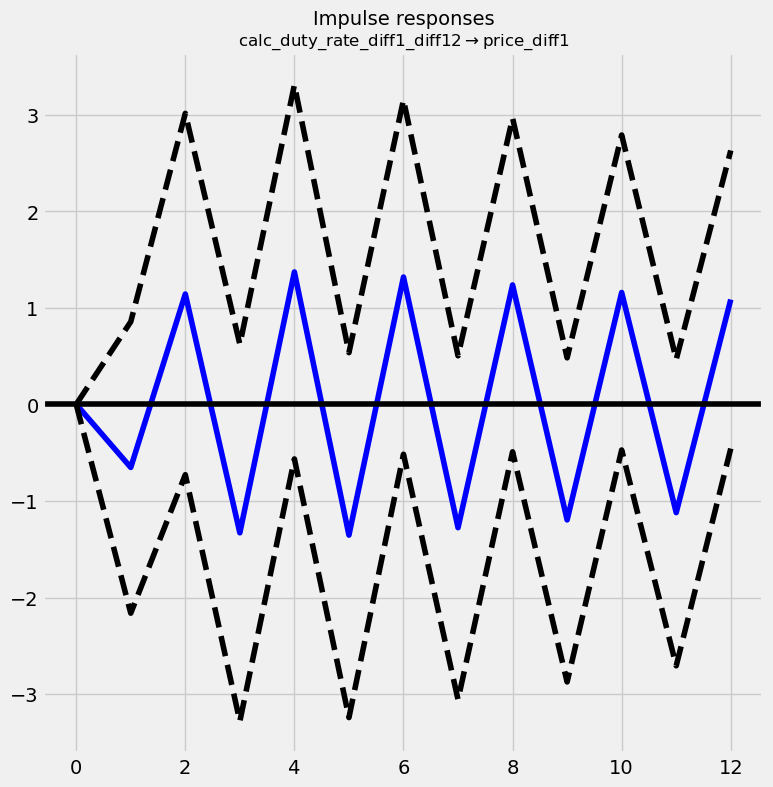

In [109]:
impulse_response = tsmf.irf(12)
impulse_response.plot(orth=False, impulse='calc_duty_rate_diff1_diff12', response='price_diff1')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()


It looks like a similar directional change in price will result from a change in the tariff rate imposed on France, Germany, Spain, and the U.K.

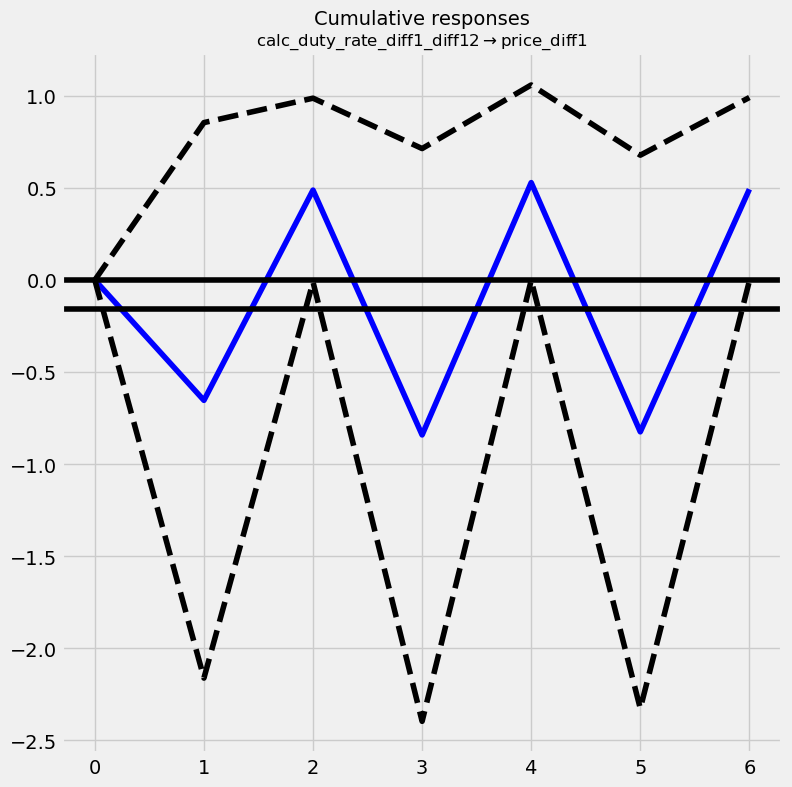

In [107]:
impulse_response = tsmf.irf(6)
impulse_response.plot_cum_effects(orth=False, impulse='calc_duty_rate_diff1_diff12', response='price_diff1')
plt.gcf().set_size_inches(8, 8)
plt.show()

### OLS

## Conclusion

The prediction accuracy looks pretty good for the Real Price variable, `price`, with a RMSE of 0.18 and a minmax getting close to zero. 